# Урок 5. Задача оттока: варианты постановки, возможные способы решения

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, \
                            precision_recall_curve, confusion_matrix

#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

Case1

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
#Посмотрим на распределение классов:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Теперь будем строить модели

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Списки признаков:

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Как это работает на примере отдельного категориального признака - Gender

In [8]:
gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Ананлогичный пример для вещественного признака (в данном случае возраст)

In [9]:
age = Pipeline([
                ('selector', FeatureSelector(column='Age')),
                
            ])
age.fit(X_train)
age.transform(X_test).head(5)

9394    35
898     40
2398    42
5906    32
2343    38
Name: Age, dtype: int64

Теперь нужно под каждый признак создать трансформер и объединять их в список (сделаем это в цикле, чтобы не мучиться)

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [12]:
pipeline_rf = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [13]:
#обучим наш пайплайн
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline_rf.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [15]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [16]:
thresholds_rf = thresholds[ix] 
fscore_rf = fscore[ix]
precision_rf = precision[ix]
recall_rf = recall[ix]

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


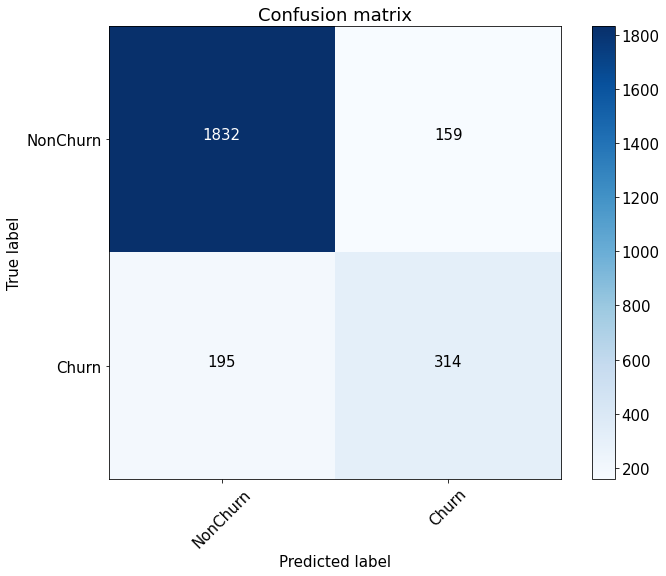

In [18]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Домашнее задание
1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [19]:
GradientBoosting_pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Обучим модель

In [20]:
#обучим наш пайплайн
GradientBoosting_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [21]:
#наши прогнозы для тестовой выборки
preds = GradientBoosting_pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.28502357, 0.22926788, 0.1982218 , 0.08930468, 0.04798288,
       0.80662596, 0.03834531, 0.05054472, 0.31038377, 0.73455865])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


In [23]:
thresholds_gb = thresholds[ix] 
fscore_gb = fscore[ix]
precision_gb = precision[ix]
recall_gb = recall[ix]

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


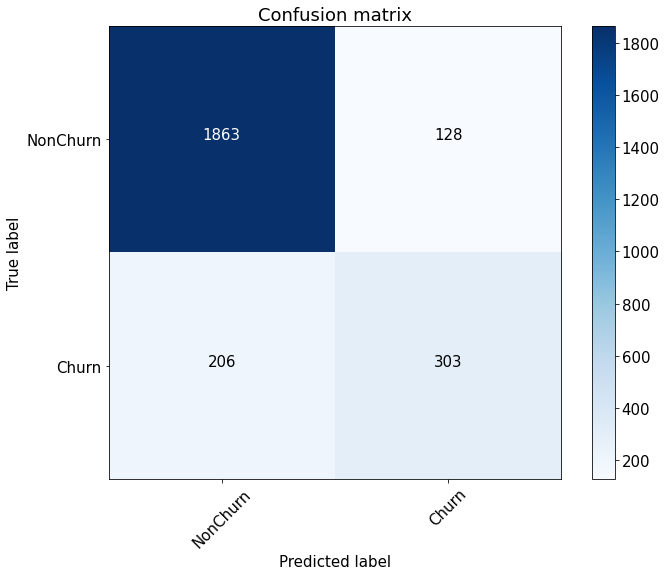

In [24]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

 2 - логистическая регрессия

In [25]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [26]:
LogisticRegression_pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [27]:
#обучим наш пайплайн
LogisticRegression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [28]:
#наши прогнозы для тестовой выборки
preds = LogisticRegression_pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22390104, 0.33707751, 0.18489566, 0.09197292, 0.18590078,
       0.40873004, 0.18821398, 0.18360246, 0.43551361, 0.70866171])

In [29]:

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall + 0.00000000000001)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.199920, F-Score=0.411, Precision=0.296, Recall=0.676


In [30]:
thresholds_lr = thresholds[ix] 
fscore_lr = fscore[ix]
precision_lr = precision[ix]
recall_lr = recall[ix]

Confusion matrix, without normalization
[[1172  819]
 [ 166  343]]


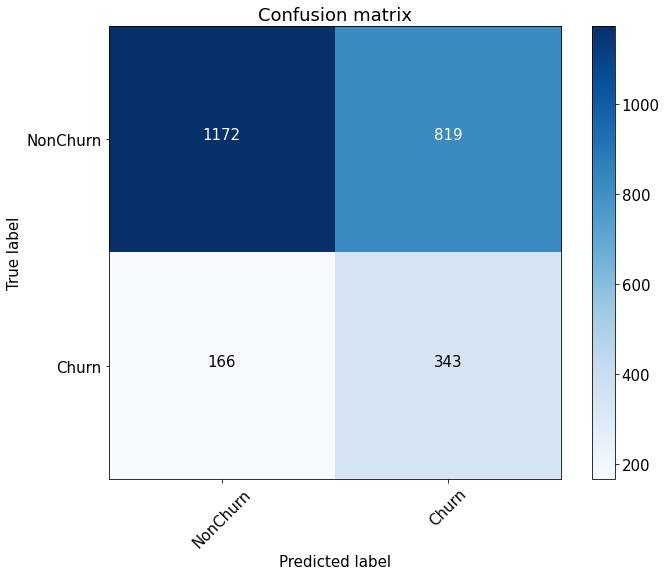

In [31]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [32]:
models = pd.DataFrame({
                      'Best Threshold':[thresholds_rf, thresholds_gb, thresholds_lr], 
                      'F-Score':[ fscore_rf, fscore_gb, fscore_lr], 
                      'Precision':[precision_rf, precision_gb, precision_lr], 
                      'Recall':[recall_rf, recall_gb, recall_lr], 
                      })

models.index = ['RandomForestClassifier','GradientBoosting', 'LogisticRegression']
models.round(2)

,Best Threshold,F-Score,Precision,Recall
RandomForestClassifier,0.38,0.64,0.65,0.63
GradientBoosting,0.41,0.65,0.70,0.60
LogisticRegression,0.20,0.41,0.30,0.68


Тут два варианта
Если нужно выделить максимум возможно собирающихся покинуть пользователей, то самая подходящая метрика здесь - Recall. Тогда лучшая модель - RandomForestClassifier	(хоть и у LogisticRegression наибольшее значение Recall, но значения Best Threshold	и F-Score наименьшие)

Если нужно выделить как можно больше истинно оставшихся клиентов, то то самая подходящая метрика здесь - Precision. Тогда лучшая модель - GradientBoosting.	

Но в данном случае выгоднее повышать Precision (получить как можно больше истинно оставшихся клиентов), чтобы  не потратить много "лишних" денег на потенциально уходящих клиентов. Бизнесу выгоднее затратить как можно меньше денег, поэтому выбираем модель GradientBoosting  

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [33]:
def economic_efficiency(cnf_matrix):

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

#выручка
    income = 2 * TP
#траты
    expense = TP*1 + FP*1  

    return TN, FN, TP, FP, income, expense

In [34]:
TN, FN, TP, FP, income, expense = economic_efficiency(cnf_matrix_gb)
TN, FN, TP, FP

(1863, 206, 303, 128)

In [35]:
print(f'Затратили: {expense} $')
print(f'Получили: {income} $')
print(f'Могли бы получить: {2 * (TP+ FN)} $')
print(f'Возможная прибыль = {income - expense} $')

Затратили: 431 $
Получили: 606 $
Могли бы получить: 1018 $
Возможная прибыль = 175 $


4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [36]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 'n_estimators': [50, 100, 150],
              'min_samples_leaf':[1, 2, 5], 'max_depth':[2, 3, 4]}

gb = GradientBoostingClassifier(random_state = 42)
gs = GridSearchCV(gb, parameters)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', gs),
])

pipeline.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'learning_rate': 0.2,
  'max_depth': 3,
  'min_samples_leaf': 2,
  'n_estimators': 100},
 0.8652)

In [37]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(learning_rate=0.2, random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.372968, F-Score=0.644, Precision=0.658, Recall=0.631


Confusion matrix, without normalization
[[1824  167]
 [ 189  320]]


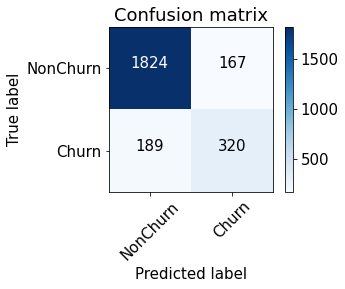

In [38]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_best = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix_best, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

5. (опционально) Еще раз провести оценку экономической эффективности

In [39]:
TN, FN, TP, FP, income, expense = economic_efficiency(cnf_matrix_best)

In [40]:
print(f'Затратили: {expense} $')
print(f'Получили: {income} $')
print(f'Могли бы получить: {2 * (TP+ FN)} $')
print(f'Возможная прибыль = {income - expense} $')

Затратили: 487 $
Получили: 640 $
Могли бы получить: 1018 $
Возможная прибыль = 153 $
